## Readme
The table of contents can be found on the left of the google colab file.
To use the file, you need to change the directory to your own directory/ upload the datasets to your google drive.
<br><br>
To use the machine learning models, you will need to run the cells in:

*   Import the libraries
*   Mount Google Drive to run code on Google Colab (if you plan to run the file on Google Colab)
*   Reading the data
*   Machinie Learning
*   Using the model to predict the results of test datasets
<br><br>

There are two models in this file, Support Vector Regression (SVR) and Long Short Term Memory (LSTM). Some cells are marked as to be used only with either SVR or LSTM models.

*   As the number of training datasets is very small, SVR will be more effective.
*   LSTM is effective at capturing sequential dependencies in data, but needs larger datasets.

<br><br>
Due to time constraint, we could not do analysis on the extra seismic events data.


### Import the libraries

In [2]:
# Import libraries
!pip install obspy
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras

### Mount Google Drive to run code on google colab

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Reading the data

In [4]:
path = '/content/drive/MyDrive/space_apps_2024_seismic_detection/data/lunar/training/catalogs'

cat = pd.read_csv(path + '/apollo12_catalog_GradeA_final.csv')
cat.head()

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq


###Select Detection

In [ ]:
row = cat.iloc[6]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time

datetime.datetime(1970, 6, 26, 20, 1)

In [ ]:
# If we want the value of relative time, we don't need to use datetime
arrival_time_rel = row['time_rel(sec)']
arrival_time_rel

72060.0

In [ ]:
# Let's also get the name of the file
test_filename = row.filename
test_filename

'xa.s12.00.mhz.1970-06-26HR00_evid00009'

### Read CSV

In [ ]:
data_directory = '/content/drive/MyDrive/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/'
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)
data_cat

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1970-06-26T00:00:00.116000,0.000000,-6.727977e-16
1,1970-06-26T00:00:00.266943,0.150943,-8.646711e-16
2,1970-06-26T00:00:00.417887,0.301887,-9.298738e-16
3,1970-06-26T00:00:00.568830,0.452830,-8.589095e-16
4,1970-06-26T00:00:00.719774,0.603774,-7.139047e-16
...,...,...,...
572418,1970-06-27T00:00:02.832981,86402.716981,5.039820e-17
572419,1970-06-27T00:00:02.983925,86402.867925,-9.191068e-18
572420,1970-06-27T00:00:03.134868,86403.018868,-2.796955e-17
572421,1970-06-27T00:00:03.285811,86403.169811,-9.037156e-17


#### relative time

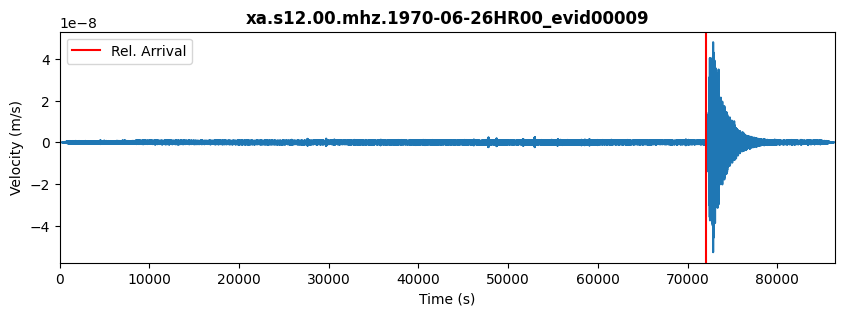

In [ ]:
# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace!
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])

#### absolute time

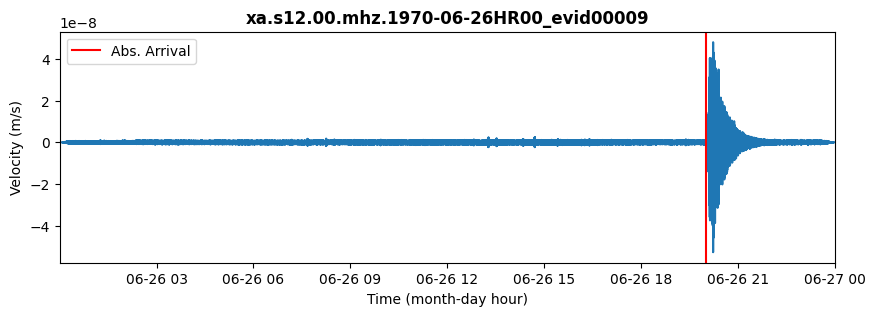

In [ ]:
# Read in time steps and velocities
csv_times_dt = []
for absval_str in data_cat['time_abs(%Y-%m-%dT%H:%M:%S.%f)'].values:
    csv_times_dt.append(datetime.strptime(absval_str,'%Y-%m-%dT%H:%M:%S.%f'))

csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace!
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times_dt,csv_data)

# Make the plot pretty
ax.set_xlim((np.min(csv_times_dt),np.max(csv_times_dt)))
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (month-day hour)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
ax.legend(handles=[arrival_line])

###Read Miniseed

In [ ]:
mseed_file = f'{data_directory}{test_filename}.mseed'
st = read(mseed_file)
st

1 Trace(s) in Stream:
XA.S12.00.MHZ | 1970-06-26T00:00:00.116000Z - 1970-06-27T00:00:03.436755Z | 6.6 Hz, 572423 samples

#### header info

In [ ]:
st[0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1970-06-26T00:00:00.116000Z
         endtime: 1970-06-27T00:00:03.436755Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572423
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

In [ ]:
# This is how you get the data and the time, which is in seconds
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

# Start time of trace (another way to get the relative arrival time using datetime)
starttime = tr.stats.starttime.datetime
arrival = (arrival_time - starttime).total_seconds()
arrival

72059.884

### Machine Learning

In [5]:
train_data = pd.DataFrame(cat, columns=['filename', 'time_rel(sec)'])
print(train_data)

                                  filename  time_rel(sec)
0   xa.s12.00.mhz.1970-01-19HR00_evid00002        73500.0
1   xa.s12.00.mhz.1970-03-25HR00_evid00003        12720.0
2   xa.s12.00.mhz.1970-03-26HR00_evid00004        73020.0
3   xa.s12.00.mhz.1970-04-25HR00_evid00006         4440.0
4   xa.s12.00.mhz.1970-04-26HR00_evid00007        52140.0
..                                     ...            ...
71  xa.s12.00.mhz.1974-10-14HR00_evid00156        63780.0
72  xa.s12.00.mhz.1975-04-12HR00_evid00191        65700.0
73  xa.s12.00.mhz.1975-05-04HR00_evid00192        36300.0
74  xa.s12.00.mhz.1975-06-24HR00_evid00196        57780.0
75  xa.s12.00.mhz.1975-06-26HR00_evid00198        12240.0

[76 rows x 2 columns]


In [6]:
test_filename = train_data['filename']
print(test_filename)

0     xa.s12.00.mhz.1970-01-19HR00_evid00002
1     xa.s12.00.mhz.1970-03-25HR00_evid00003
2     xa.s12.00.mhz.1970-03-26HR00_evid00004
3     xa.s12.00.mhz.1970-04-25HR00_evid00006
4     xa.s12.00.mhz.1970-04-26HR00_evid00007
                       ...                  
71    xa.s12.00.mhz.1974-10-14HR00_evid00156
72    xa.s12.00.mhz.1975-04-12HR00_evid00191
73    xa.s12.00.mhz.1975-05-04HR00_evid00192
74    xa.s12.00.mhz.1975-06-24HR00_evid00196
75    xa.s12.00.mhz.1975-06-26HR00_evid00198
Name: filename, Length: 76, dtype: object


####import train data

In [32]:
time_rel = cat['time_rel(sec)']

print(time_rel)

0     73500.0
1     12720.0
2     73020.0
3      4440.0
4     52140.0
       ...   
71    63780.0
72    65700.0
73    36300.0
74    57780.0
75    12240.0
Name: time_rel(sec), Length: 76, dtype: float64


In [33]:
data_directory = '/content/drive/MyDrive/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/'

x = []
time = [] #relative time in training datasets
velocity = [] #velocity in training datasets
for i in range (len(cat.filename)):
  mseed_file = f'{data_directory}{cat.filename[i]}.mseed'
  st = read(mseed_file)
  tr = st.traces[0].copy()
  tr_times = tr.times()
  tr_data = tr.data
  x.append([tr_times, tr_data])
  time.append(tr_times)
  velocity.append(tr_data)

Text(0.5, 1.0, 'xa.s12.00.mhz.1970-06-26HR00_evid00009')

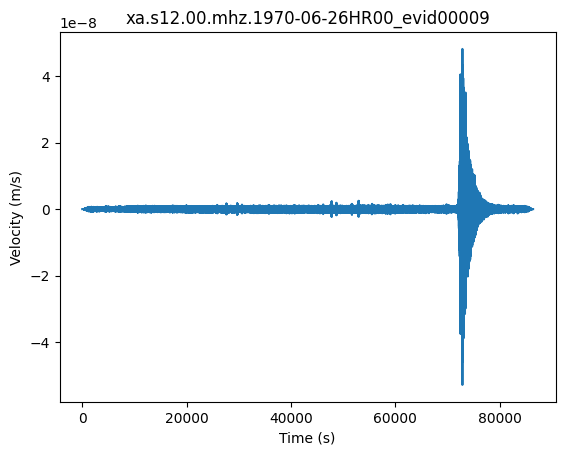

In [34]:
# plotting the data to see if the files are imported correctly
plt.plot(time[6], velocity[6])
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title(f'{cat.filename[6]}')

#### Import test data

In [35]:
test_data_directory = '/content/drive/MyDrive/space_apps_2024_seismic_detection/data/lunar/test/data/'

dir = ['S12_GradeB', 'S15_GradeA', 'S15_GradeB', 'S16_GradeA', 'S16_GradeB'] #list of test data folders
dir_list = []
for i in range(len(dir)):
  dir_list.append(test_data_directory+dir[i])
print(dir_list)


['/content/drive/MyDrive/space_apps_2024_seismic_detection/data/lunar/test/data/S12_GradeB', '/content/drive/MyDrive/space_apps_2024_seismic_detection/data/lunar/test/data/S15_GradeA', '/content/drive/MyDrive/space_apps_2024_seismic_detection/data/lunar/test/data/S15_GradeB', '/content/drive/MyDrive/space_apps_2024_seismic_detection/data/lunar/test/data/S16_GradeA', '/content/drive/MyDrive/space_apps_2024_seismic_detection/data/lunar/test/data/S16_GradeB']


In [36]:
file_list = []
for folder in dir_list:
  files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.mseed')]
  file_list.extend(files)

len(file_list)

96

In [37]:
test_time = []
test_velocity = []
test_x = []
for i in file_list:
  st = read(i)
  tr = st.traces[0].copy()
  tr_times = tr.times()
  tr_data = tr.data
  test_x.append([tr_times, tr_data])
  test_time.append(tr_times)
  test_velocity.append(tr_data)
#print(test_x)

#### Preparing the data

##### Padding the data

In [38]:
max_len = 0
for i in range(len(velocity)):
  #print(len(velocity[i]))
  if len(velocity[i]) > max_len:
    # print(i)
    max_len = len(velocity[i])

for i in range(len(test_velocity)):
  #print(len(velocity[i]))
  if len(test_velocity[i]) > max_len:
    # print(i)
    max_len = len(test_velocity[i])

print('maximum number of data points in a file=',max_len)

maximum number of data points in a file= 572443


In [39]:
#to have test and training data in the same dimensions
for i in range(len(velocity)):
  velocity[i] = np.pad(velocity[i], (0, max_len - len(velocity[i])), mode='constant')
  time[i] = np.pad(time[i], (0, max_len - len(time[i])), mode='constant')

for i in range(len(test_velocity)):
  test_velocity[i] = np.pad(test_velocity[i], (0, max_len - len(test_velocity[i])), mode='constant')
  test_time[i] = np.pad(test_time[i], (0, max_len - len(test_time[i])), mode='constant')

In [40]:
vel = np.array(velocity)
print('shape of traning velocities = ', vel.shape)

test_vel = np.array(test_velocity)
print('shape of testing velocities = ', test_vel.shape)

shape of traning velocities =  (76, 572443)
shape of testing velocities =  (96, 572443)


##### Data Augmentation for training datasets
As there isn't enough data, data augmentation is needed to train the LSTM model.

Unfortunately, although these codes work, the kernel will crash due to RAM issues. If you would like to do data augmentation, I recommend trying running the magnitude shifting/time shifting no more than twice in each loop.

In [16]:
# finding time steps between the relative timestamps
interval = time[0][1]-time[0][0]
print(interval)

0.1509433962264151


In [17]:
#Magnitude Scaling Method
scale_factor = np.random.uniform(low=0.8, high=1.2)
#augmented_data = train_x * scale_factor

def magnitude_shift(data):
  for i in range(len(data)):
    scale_factor = np.random.uniform(0,1)
    data[i] = data[i] * scale_factor
  return data

def time_shift(data, shift):
  for i in range(len(data)):
    data[i] = np.roll(data[i], shift, axis=0)
  return data

#To repeat magnitude shifting:
def repeat_func_vel(times, data1): #data needs to be duplicated before passing into the function as the function update the original data
    for i in range(times): #number of times it creates new datasets = 'times+1'
      data2 = magnitude_shift(data1)
      data1 = np.concatenate([data1, data2], axis=0)
    return data1

def repeat_func_time(times, data1):
  for i in range(times):
    data2 = data1.copy()
    data1 = np.concatenate([data1, data1], axis=0)
  return data1



In [ ]:
# To repeat magnitude shifting
num_mag = 1 #number of magnitude shifting done
augmented_vel = vel.copy()
augmented_time = time.copy()

augmented_vel = repeat_func_vel(num_mag, augmented_vel)
augmented_time = repeat_func_time(num_mag, augmented_time)

print('shape of augmented training velocity is',augmented_vel.shape)
print('shape of augmented training time is',augmented_time.shape)

In [17]:
#To repeat time shifting
for j in range(1): #number of time shifting done
  train_aug = time_shift(vel, shift=j)
  augmented_vel = np.concatenate([augmented_vel, train_aug], axis=0)
  time_aug = time + j*interval
  augmented_time = np.concatenate([augmented_time, time_aug], axis=0)


print('shape of augmented training velocity is',augmented_vel.shape)
print('shape of augmented training time is',augmented_time.shape)

shape of augmented training velocity is (456, 572443)
shape of augmented training time is (456, 572443)


##### Scaling the data

In [18]:
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

scaler = preprocessing.MinMaxScaler()
#scaler = preprocessing.StandardScaler()

In [19]:
# Run this if you applied data augmentation, else, use the cell below
#scale the train data
augmented_vel_transposed = augmented_vel.T
# Apply MinMaxScaler to the transposed data
scaled_augmented_vel_transposed = scaler.fit_transform(augmented_vel_transposed)

# Transpose back to the original shape
scaled_augmented_vel = scaled_augmented_vel_transposed.T

print(scaled_augmented_vel.shape)  # Check for correct shape

NameError: name 'augmented_vel' is not defined

In [41]:
#scale the train data
vel_transposed = vel.T

# Apply MinMaxScaler to the transposed data
scaled_vel_transposed = scaler.fit_transform(vel_transposed)

# Transpose back to the original shape
scaled_vel = scaled_vel_transposed.T

print(scaled_vel.shape)  # Check for correct shape

(76, 572443)


In [42]:
#scale the test data
test_vel_transposed = test_vel.T

# Apply MinMaxScaler to the transposed data
scaled_test_vel_transposed = scaler.fit_transform(test_vel_transposed)

# Transpose back to the original shape
scaled_test_vel = scaled_test_vel_transposed.T

print(scaled_test_vel.shape) # check for correct shape

(96, 572443)


[0.52322831 0.52322831 0.5232283  ... 0.52322831 0.52322831 0.52322831]


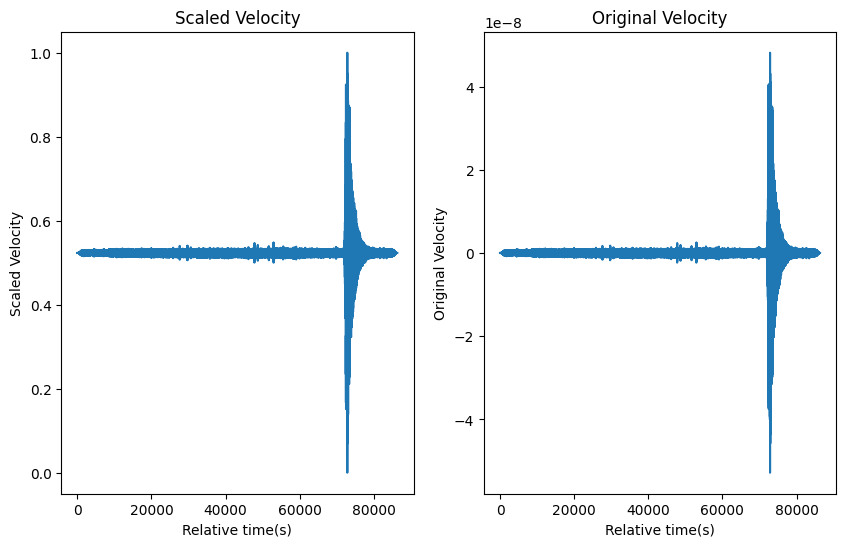

In [43]:
# Checking the shape of scaled data with original data
print(scaled_vel[6])
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1, title = 'Scaled Velocity')
plt.xlabel('Relative time(s)')
plt.ylabel('Scaled Velocity')
plt.plot(time[6],scaled_vel[6])

plt.subplot(1,2,2, title='Original Velocity')
plt.xlabel('Relative time(s)')
plt.ylabel('Original Velocity')
plt.plot(time[6],velocity[6])

#### SVR model

In [53]:
train_x = scaled_vel
train_y = time_rel
test_x = scaled_test_vel

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)

(76, 572443)
(76,)
(96, 572443)


In [54]:
from sklearn.svm import SVR
model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

model.fit(train_x, train_y)

SVR()

In [49]:
predict_time = model.predict(test_x)

#### LSTM Model

In [25]:
# Use this tab if you applied data augmentation, else use the tab below
# checking for the right shape of training and test data
train_x = scaled_augmented_vel
train_y = augmented_time
test_x = scaled_test_vel

train_x = np.expand_dims(train_x, axis=1)
train_y = np.expand_dims(train_y, axis=1)
test_x = np.expand_dims(test_x, axis=1)

print('shape of train_x is',train_x.shape)
print('shape of train_y is',train_y.shape)
print('shape of test_x is',test_x.shape)

shape of train_x is (456, 1, 572443)
shape of train_y is (456, 1, 572443)
shape of test_x is (96, 1, 572443)


In [24]:
train_x = scaled_vel
train_y = time
test_x = scaled_test_vel

train_x = np.expand_dims(train_x, axis=1)
train_y = np.expand_dims(train_y, axis=1)
test_x = np.expand_dims(test_x, axis=1)

print('shape of train_x is',train_x.shape)
print('shape of train_y is',train_y.shape)
print('shape of test_x is',test_x.shape)

shape of train_x is (76, 1, 572443)
shape of train_y is (76, 1, 572443)
shape of test_x is (96, 1, 572443)


In [25]:
BatchSize = 16
Nepochs = 150
learning_rate = 0.01
ValidationSplit = 0.3


model = tf.keras.models.Sequential([
tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True),

tf.keras.layers.LSTM(32, activation='tanh', return_sequences=True),
tf.keras.layers.Dropout(0.2),

#tf.keras.layers.LSTM(16,  return_sequences=True),

tf.keras.layers.Flatten(),
#tf.keras.layers.Dense(32,activation='linear'),

tf.keras.layers.Dense(16,activation='linear'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(1)#, activation='linear')
])

loss_fn = tf.keras.losses.MSE

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=loss_fn, metrics=['mae'])

In [26]:
# Use augmented data in your model training

history = model.fit(x=train_x, y=train_y, validation_split=ValidationSplit,
                    batch_size=BatchSize, epochs=Nepochs)

model.summary()
print(history.history.keys())


Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - loss: 2446056448.0000 - mae: 42629.9805 - val_loss: 2487867136.0000 - val_mae: 43193.6758
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - loss: 2445648896.0000 - mae: 42625.2812 - val_loss: 2487237120.0000 - val_mae: 43186.3906
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - loss: 2444995584.0000 - mae: 42617.7422 - val_loss: 2486361856.0000 - val_mae: 43176.2539
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - loss: 2418496512.0000 - mae: 42265.2930 - val_loss: 2485316096.0000 - val_mae: 43164.1523
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - loss: 2393194752.0000 - mae: 41908.7109 - val_loss: 2484139520.0000 - val_mae: 43150.5391
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - loss: 2448349952.0000 - mae: 42663.6055 - val_loss: 2482812160.0000 - val_mae: 43135.1758
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - loss: 2415004928.0000 - mae: 42225.0430 - val_loss: 2481309696.0000 - val_mae: 43117.7891
Epoch 8/150
4

KeyboardInterrupt: 

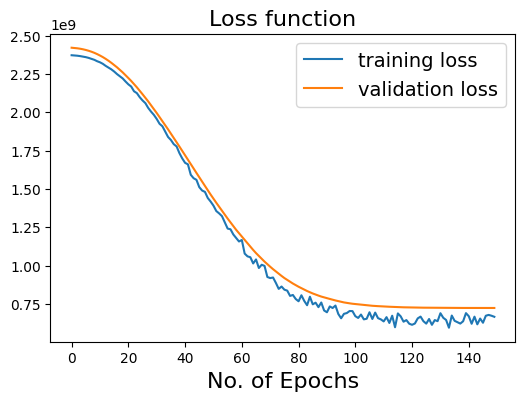

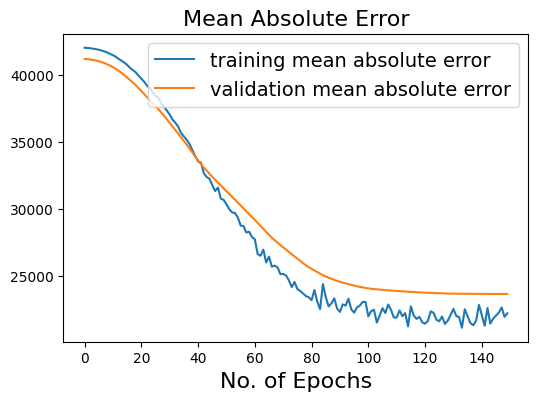

In [47]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend(fontsize=14)
plt.title('Loss function', fontsize=16)
plt.xlabel('No. of Epochs', fontsize=16)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history.history['mae'], label='training mean absolute error')
plt.plot(history.history['val_mae'], label = 'validation mean absolute error')
plt.legend(fontsize=14)
plt.title('Mean Absolute Error', fontsize=16)
plt.xlabel('No. of Epochs', fontsize=16)
plt.show()

### Using the model to predict the results of test datasets

In [34]:
predict_time = model.predict(test_x)
#print(predict_time)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


In [55]:
#for LSTM model
test_prediction = []
for i in range(len(test_x)):
    predict = predict_time[i][0]
    test_prediction.append(predict)

In [58]:
#for SVR model

test_prediction = predict_time

#### Plotting the prediction of the models

Text(0.5, 0, 'Time (s)')

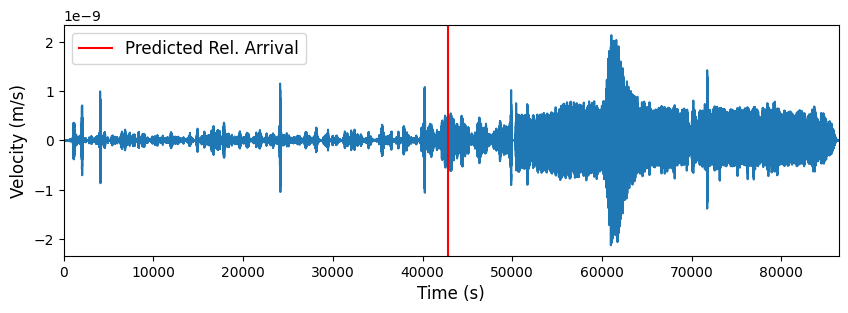

In [74]:
i =7
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(test_time[i],test_velocity[i])

# Mark detection
ax.axvline(x = test_prediction[i], color='red',label='Predicted Rel. Arrival')
ax.legend(loc='upper left', fontsize=12)

# Make the plot pretty
ax.set_xlim([min(test_time[i]),max(test_time[i])])
ax.set_ylabel('Velocity (m/s)', fontsize=12)
ax.set_xlabel('Time (s)', fontsize=12)
#ax.set_title(f'{test_filename}', fontweight='bold')

#### Running the model on the train data and compare with the actual arrival time

In [64]:
#SVR model
train_prediction = model.predict(train_x)

In [65]:
#LSTM model
predict_train = model.predict(train_x)
train_prediction = []
train_prediction = []
for i in range(len(train_x)):
    predict = predict_train[i][0]
    train_prediction.append(predict)

KeyboardInterrupt: 

Text(0.5, 0, 'Time (s)')

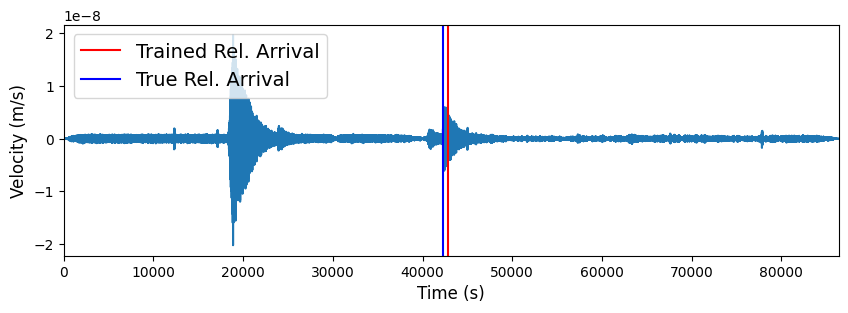

In [72]:
i =8
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(time[i], velocity[i])

# Mark detection
ax.axvline(x = train_prediction[i], color='red',label='Trained Rel. Arrival')
ax.axvline(x = time_rel[i], color='blue',label='True Rel. Arrival')
ax.legend(loc='upper left', fontsize=14)

# Make the plot pretty
ax.set_xlim([min(time[i]),max(time[i])])
ax.set_ylabel('Velocity (m/s)', fontsize=12)
ax.set_xlabel('Time (s)', fontsize=12)
#ax.set_title(f'{test_filename}', fontweight='bold')

### Extra seismic events data

In [ ]:
!pip install pyweed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.5/270.5 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
  Attempting uninstall: obspy
    Found existing installation: obspy 1.4.1
    Uninstalling obspy-1.4.1:
      Successfully uninstalled obspy-1.4.1
